In [ ]:
#@title Datastore Class

import numpy as np

class Singleton(type):
    _instances = {}
    def __call__(cls, *args, **kwargs):
        if cls not in cls._instances:
            cls._instances[cls] = super(Singleton, cls).__call__(*args, **kwargs)
        return cls._instances[cls]

class Datastore(metaclass=Singleton):

  def __init__(self):
    self.data = {}

  def get_size(self):
    return len(self.data)

  def get_data(self, annotations, root_dir):

    size = len(annotations.index)

    if len(self.data) != size:
      print("Preloading dataset")
      for i in tqdm(range(0,size)):

        learnData = torch.Tensor()
        for j in range(5):

          data_path = os.path.join(root_dir,'GramsVer2', annotations.iloc[i,0] +str(j))
          learnData = torch.cat((learnData, torch.load(data_path).flatten()),0)
          #learnData.append(torch.load(data_path).flatten())

        data_path = os.path.join(root_dir,'CoreColors', annotations.iloc[i,0] + "_Colors.npy")

        #learnData.append(np.load(data_path).flatten())
        learnData = torch.cat((learnData, torch.from_numpy(np.load(data_path).flatten())),0)
        self.data[i] = learnData
        #print(learnData)


      #print("data already preloaded, returning")
    return self.data

  def reset():
    self.data = {}



In [ ]:
#@title Dataset Class

import os
import pandas as pd
import torch
from torch.utils.data import Dataset
#from skimage import io

class smallShaderDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(os.path.join(root_dir,csv_file))
    self.root_dir = root_dir
    self.transform = transform
    self.data_store = Datastore()


  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):

    # if self.data_store is None:
    #   data_path = os.path.join(self.root_dir,'LearnDataCombined', self.annotations.iloc[index,0] + ".npy")
    #   input = np.load(data_path)
    # else:
    input = self.data_store.get_data(annotations=self.annotations, root_dir=self.root_dir)[index]

    parameters = self.annotations.iloc[index,1:]
    parameters = np.array([parameters],dtype = float).flatten()
    input = np.array(input,dtype = float)

    sample = {'input': input, 'parameters': parameters}

    #Maybe think about transforms for data augmentation. Not sure if
    #augmentation is possible on gram matrices. maybe they have to be done before the gram calculation is done
    #if self.transform:
    #  sample = self.transform(sample)

    #sample.ToTensor()

    #print(input, parameters)

    return input, parameters




#Define, Train and Test the NN

This code is from a youtuber I found who does a great job explaining what he is doing. it is origianally made to classify hand written digits.
I will try to get it to work for my case here. Problem might be that parametrization and classifications is a very different problem.
On the other side if I understand NN correctly, it shouldnt really make a difference.
https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/Basics/pytorch_simple_fullynet.py

very good resource aswell: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Dataloader seams to have a problmem with my Dataset. Error message is very much not helpful. Maybe I have to write my custom "collate" function. I am not yet sure what that function is doing though.
Maybe I have an error in my __getitem__ function in the Dataset class. But as far as i see are both parts of the tuple lists. which should be fine. Atleast I thought so.


In [ ]:
#@title Accuracy funcion
#@markdown Check accuracy on training & test to see how good our model
#@markdown this does not work for this task, needs a complete rework, linear difference between parameters might be enough (hopefully), if not, render image, make grams, compare grams?
import pdb

def check_accuracy(loader, model, verbose=False):

  with torch.no_grad():
        diff = 0
        count = 0
        for data, labels in loader:
            #print(data)
            data = data.to(device=device)
            labels = labels.to(device=device)
            #data = data.reshape(data.shape[0], -1)

            scores = model(data.float())

            diff += torch.mean(torch.absolute(scores - labels))
            if verbose:
              #pdb.set_trace()
              print("\033[95m" + str(torch.mean(data)) + " - " + str(torch.median(data)))
              print("\033[93m" + str(scores.float()))
              print("\x1B[37m" + str(labels.float()))
            #print(diff)
            count += 1



  return 1 - (diff / count)

In [ ]:


# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
#import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
import numpy as np
import matplotlib.pyplot as plt

output_layer_names = ['block1_conv2',
                      'block2_conv2',
                      'block3_conv4',
                      'block4_conv4']

# Here we create our simple neural network. For more details here we are subclassing and
# inheriting from nn.Module, this is the most general way to create your networks and
# allows for more flexibility. I encourage you to also check out nn.Sequential which
# would be easier to use in this scenario but I wanted to show you something that
# "always" works.
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        # Our first linear layer take input_size, in this case 348170 node (!!!) compressing that to 300 sucks. how to deal with that much data?
        self.fc1 = nn.Linear(input_size, 1000, bias=False)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 100)
        # self.fc4 = nn.Linear(100, 100)
        # self.fc5 = nn.Linear(100, 100)
        # self.fc6 = nn.Linear(100, 100)
        # self.fc7 = nn.Linear(100, 100)
        # self.fc8 = nn.Linear(100, 100)
        self.fc9 = nn.Linear(100, num_classes, bias=False)

    def forward(self, x):
        """
        x here is the mnist images and we run it through fc1, fc2 that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters)
        I recommend using nn.functional (F)
        """
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        # x = self.fc4(x)
        # x = F.relu(x)
        # x = self.fc5(x)
        # x = F.relu(x)
        # x = self.fc6(x)
        # x = F.relu(x)
        # x = self.fc7(x)
        # x = F.relu(x)
        # x = self.fc8(x)
        # x = F.relu(x)
        x = self.fc9(x)
        x = torch.sigmoid(x)
        return x


In [ ]:
#@title Train

import time
import pdb

def train():

  # Train Network
  torch.save(model, root_dir + "\Models\\epoch_init.model")
  for epoch in range(config.num_epochs):


      for batch_idx, (data, targets) in (enumerate(train_loader)):
          # Get data to cuda if possible
          data = data.to(device=device)
          targets = targets.to(device=device)

          # Get to correct shape
          #data = data.reshape(data.shape[0], -1)

          # forward
          scores = model(data.float())
          loss = criterion(scores, targets.float())
          #pdb.set_trace()

          #pdb.set_trace()
          wandb.log({"loss": loss})

          # backward
          optimizer.zero_grad()
          loss.backward()

          #print("targets: " + str(targets))
          #print("scores: " + str(scores))

          #pdb.set_trace()
          # gradient descent or adam step
          optimizer.step()
          #print("done step")



      if (epoch % 20 == 0):
        print(str(time.ctime()) + "  -  epoch: "+str(epoch))
        acc = check_accuracy(test_loader, model)

        trainAcc = check_accuracy(train_loader, model)

        wandb.log({ "Train Acc": trainAcc, "Test Acc": acc })
        print(f"Accuracy on test/train set: {acc :.2f}/{trainAcc :.2f}")


        torch.cuda.empty_cache()
      if (epoch % 400 == 0):
        acc = check_accuracy(train_loader, model, verbose=True)
        try:
          torch.save(model, root_dir + "\Models\\epoch_"+str(epoch)+".model")
        except Exception as e:
          print("saving model didnt work")


  print(f"Accuracy on training set: {check_accuracy(train_loader, model):.2f}")
  print(f"Accuracy on test set: {check_accuracy(test_loader, model):.2f}")

https://stats.stackexchange.com/questions/261704/training-a-neural-network-for-regression-always-predicts-the-mean

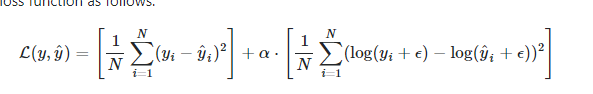

In [ ]:
#@title Mean Squared Log-scaled Error Loss
import pdb

class MSLELoss(nn.Module):
    def __init__(self, logPart = 15):
      super().__init__()
      self.mse = nn.MSELoss()
      self.a = logPart

    def forward(self, pred, actual):
      ret = self.mse(pred,actual) + self.a * (self.mse(torch.log(pred+0.0000001),torch.log(actual+0.0000001)))
      return ret

In [ ]:
#@title Here is the learning part
import wandb
import matplotlib.pyplot as plt
# Set device cuda for GPU if it's available otherwise run on the CPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("running on " + str(device))

def in_colab():
  import sys
  return 'google.colab' in sys.modules



wandb.init(project='blender small stone dataset', entity='liquidmasl')

config = wandb.config

# Hyperparameters of our neural network which depends on the dataset, and
# also just experimenting to see what works well (learning rate for example).
config.input_size = 610313   #Number of input pixels, this is just the grams and 3 key colors
config.num_classes = 9       #number of parameters
config.learning_rate = 0.0000001
config.batch_size = 1
config.num_epochs = 5000
config.criterion = ""
config.NN = ""
config.loss_log_part = 20

# Load Training and Test data
#train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
#test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)




if in_colab():
  #root_dir = '/content/drive/MyDrive/Datasets/MiniStoneShaderDataset'
  root_dir = '/content/drive/MyDrive/Datasets/MiniStoneShaderDataset'
else:
  #root_dir = 'D:\Dropbox\Masl Stuff\BachelorArbeit\Google drive (to colab)\Datasets\MiniStoneShaderDataset'

  root_dir = R'C:\Users\mwinkelmueller\Dropbox\Masl Stuff\BachelorArbeit\Datasets\BiggerShaderDataset'


if __name__ ==  '__main__':
  dataset = smallShaderDataset(csv_file='Labels.csv', root_dir=root_dir )
  print(len(dataset))


# randomly split training and testing set
  train_dataset, test_dataset = torch.utils.data.Subset(dataset, range(0,2)),torch.utils.data.Subset(dataset, [10])
  #train_dataset, test_dataset = torch.utils.data.random_split(dataset, [9900, 99])
  #train_dataset, test_dataset = torch.utils.data.Subset(dataset, range(0,100)),torch.utils.data.Subset(dataset, range(101,111))

  train_loader = DataLoader(dataset=train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0, pin_memory= True) #, persistent_workers = True)
  test_loader = DataLoader(dataset=test_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0, pin_memory= True) #, persistent_workers = True)

  # Initialize network
  model = NN(input_size=config.input_size, num_classes=config.num_classes).to(device)
  config.NN = str(model)
  wandb.watch(model)

  # Loss and optimizer
  #criterion = nn.CrossEntropyLoss() # cross entropy loss is used for probability outputs, so this might not be optimal at all.
  #criterion = nn.MSELoss()
  #criterion = nn.L1Loss()
  criterion = MSLELoss(config.loss_log_part)
  config.criterion = str(criterion)
  optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

  print(f"Accuracy on training set: {check_accuracy(train_loader, model):.2f}")
  print(f"Accuracy on test set: {check_accuracy(test_loader, model):.2f}")

  train()





running on cuda


wandb: Currently logged in as: liquidmasl (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


9999
Preloading dataset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [06:30<00:00, 25.59it/s]


Accuracy on training set: 0.75
Accuracy on test set: 0.81
Thu Jan 13 22:54:57 2022  -  epoch: 0
Accuracy on test/train set: 0.81/0.75
tensor(0.3897, device='cuda:0', dtype=torch.float64) - tensor(0.3744, device='cuda:0', dtype=torch.float64)
tensor([[0.4924, 0.4913, 0.4976, 0.4884, 0.4988, 0.5098, 0.5073, 0.4943, 0.4972]],
       device='cuda:0')
tensor([[0.2463, 0.2197, 0.4590, 0.0975, 0.1096, 0.7192, 0.8364, 0.5400, 0.9497]],
       device='cuda:0')
tensor(0.3900, device='cuda:0', dtype=torch.float64) - tensor(0.3748, device='cuda:0', dtype=torch.float64)
tensor([[0.4924, 0.4912, 0.4977, 0.4883, 0.4987, 0.5098, 0.5075, 0.4944, 0.4972]],
       device='cuda:0')
tensor([[0.0410, 0.0398, 0.4492, 0.5020, 0.4727, 0.2448, 0.8921, 0.1143, 0.3635]],
       device='cuda:0')
Thu Jan 13 22:55:08 2022  -  epoch: 20
Accuracy on test/train set: 0.82/0.77
Thu Jan 13 22:55:11 2022  -  epoch: 40
Accuracy on test/train set: 0.83/0.79
Thu Jan 13 22:55:15 2022  -  epoch: 60
Accuracy on test/train set: 0

RuntimeError: ignored

In [ ]:
%debug


> c:\users\mwinke~1\appdata\local\temp\ipykernel_1972\3724494547.py(38)get_data()

ipdb> q


In [ ]:
i,j = "",""
for i  in train_loader:
  print("i = " + str(i))
  print("j = " + str(j))
  break

i = tensor([[0.2463, 0.2197, 0.4590, 0.0975, 0.1096, 0.7192, 0.8364, 0.5400, 0.9497]],
       dtype=torch.float64)
j = 


In [ ]:
loss

NameError: ignored

# install steps on new machine:

1. install conda
2. make new environment
3. enter environment
4. https://pytorch.org/get-started/locally/#anaconda (use most up to date cuda that is advertised there, not newest from nvidea
5. install jupyter
6. install jupyter over https https://research.google.com/colaboratory/local-runtimes.html
6. install dependencies:

In [ ]:
!pip install pandas
!pip install tqdm
!pip install numpy
!pip install matplotlib
!pip install wandb -qqq

In [ ]:
import time
from tqdm import tqdm
import torch
import torchvision

def train(data_loader):
    start = time.time()
    for _ in tqdm(range(10)):
        for x in data_loader:
            pass
    end = time.time()
    return end - start

if __name__ == '__main__':
    train_dataset = torchvision.datasets.FashionMNIST(
        root=".", train=True, download=True,
        transform=torchvision.transforms.ToTensor()
    )

    batch_size = 32
    train_loader1 = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
    train_loader2 = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
    train_loader3 = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8, persistent_workers=True)
    train_loader4 = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=10, persistent_workers=True)

    print(train(train_loader1))
    print(train(train_loader2))
    print(train(train_loader3))
    print(train(train_loader4))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.20s/it]


42.0144419670105


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.69s/it]


26.934943437576294


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.17it/s]


8.53588342666626


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.14it/s]

8.765934228897095


In [ ]:
import time
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
import numpy as np

def train(data_loader):
    start = time.time()
    for _ in tqdm(range(10)):
        for x in data_loader:
            pass
    end = time.time()
    return end - start

if __name__ ==  '__main__':
  batch_size = 64

  root_dir = R'C:\Users\mwinkelmueller\Desktop\MiniStoneShaderDataset\MiniStoneShaderDataset'
  dataset = smallShaderDataset(csv_file='Labels.csv', root_dir=root_dir )
  train_dataset, test_dataset = torch.utils.data.random_split(dataset, [99, 9900])

  train_loader1 = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory= True)
  train_loader2 = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory= True, persistent_workers = True)
  train_loader3 = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory= True, persistent_workers = True)

  print(train(train_loader1))
  print(train(train_loader2))
  print(train(train_loader3))




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.51it/s]


3.980217933654785


  0%|                                                                                                                                                                                               | 0/10 [00:00<?, ?it/s]

In [ ]:
%debug

> c:\users\mwinkelmueller\anaconda3\envs\cuda\lib\site-packages\torch\utils\data\dataset.py(83)__getattr__()
     81             return function
     82         else:
---> 83             raise AttributeError
     84 
     85     @classmethod

ipdb> 
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
ipdb> q


In [ ]:
#@title Dataset Class without datastore singletop cause threading

import os
import pandas as pd
import torch
from torch.utils.data import Dataset
import numpy as np

#from skimage import io

class smallShaderDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(os.path.join(root_dir,csv_file))
    self.root_dir = root_dir
    self.transform = transform
    #self.data_store = Datastore()
    #self.data = {}

    #print("Preloading dataset")
    #for i in tqdm(range(0,len(self.annotations.index))):
    #  data_path = os.path.join(root_dir,'LearnDataCombined', self.annotations.iloc[i,0] + ".npy")
    #  self.data[i] = np.load(data_path).astype(float)

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):

    # if self.data_store is None:
    #   data_path = os.path.join(self.root_dir,'LearnDataCombined', self.annotations.iloc[index,0] + ".npy")
    #   input = np.load(data_path)
    # else:
    #   input = self.data_store.get_data(annotations=self.annotations,root_dir=self.root_dir)[index]

    #input = self.data[index]
    data_path = os.path.join(self.root_dir,'LearnDataCombined', self.annotations.iloc[index,0] + ".npy")
    input = np.load(data_path)


    parameters = self.annotations.iloc[index,1:]
    parameters = np.array([parameters],dtype = float).flatten()
    input = np.array(input,dtype = float)

    sample = {'input': input, 'parameters': parameters}

    #Maybe think about transforms for data augmentation. Not sure if
    #augmentation is possible on gram matrices. maybe they have to be done before the gram calculation is done
    #if self.transform:
    #  sample = self.transform(sample)

    #sample.ToTensor()

    return input, parameters
    #return sample



In [ ]:
import torch
from torch import nn  # All neural network modules
from torch import optim  # For optimizers like SGD, Adam, etc.



criterion = nn.MSELoss()

x = torch.randn(10, 10)
y = torch.randn(10, 10).double()

loss = criterion(x, y)
print(loss)

class MSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, actual):
        return self.mse(pred,actual)

my_criterion = MSLELoss()
loss = my_criterion(x, y)
print(loss)


tensor(1.9248, dtype=torch.float64)
tensor(1.9248, dtype=torch.float64)


In [ ]:
x = torch.randn(2, 3)
y = torch.randn(5,7)


In [ ]:
torch.cat((x.flatten(), y.flatten()))

tensor([-0.7520, -0.1125,  0.4215,  1.0126, -0.8815, -0.1612, -0.1587, -0.2043,
        -1.2234, -0.0809, -1.4768,  0.8540, -1.0764, -1.5306, -0.1756, -1.2939,
        -0.5519,  0.0408, -1.0841,  0.0418,  0.9888, -0.4683,  2.1372,  0.9524,
         0.3356,  0.0187,  1.0995, -0.5083,  0.2861,  0.5331, -0.5142, -0.5931,
         1.0444, -1.0340,  1.2568, -1.5478,  0.5090, -0.8003,  1.7369, -0.2373,
         0.7872])